In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from findmycells.utils import load_zstack_as_array_from_single_planes

In [23]:
hund = [elem for elem in range(0)]

In [20]:
if len(hund) > 1:
    plane_id = hund[int(len(hund)/2)]
else:
    plane_id = hund[0]
    
plane_id

1

In [25]:
hund2 = hund.copy()

In [3]:
segmentations_dir_path = Path('/mnt/c/Users/dsege/TEMP/test_project_multiple_rois/04_quantified_segmentations/SN/')

In [7]:
zstack = load_zstack_as_array_from_single_planes(path = segmentations_dir_path, file_id = '0000')

In [8]:
zstack.shape

(1, 6519, 2471)

In [6]:
zstack.shape

(2, 6519, 2471)

In [85]:
planes = [0, 1, 2, 6, 7, 8, 9]

In [86]:
distance_to_next_plane = list()
for index in range(len(planes) - 1):
    distance_to_next_plane.append(planes[index + 1] - planes[index])
distance_to_next_plane

[1, 1, 4, 1, 1, 1]

In [91]:
from typing import List

def get_max_z_expansion(planes: List) -> int:
    z_dim_expansions = list()
    for index in range(len(planes)):
        z_dim_expansions.append(count_continous_plane_ids(start_index = index, plane_indices = planes))
    return max(z_dim_expansions)


def count_continous_plane_ids(start_index: int, plane_indices: List) -> int:
    index = start_index
    keep_going = True
    while keep_going:
        if index < len(plane_indices) - 1:
            if plane_indices[index + 1] == plane_indices[index] + 1:
                if index < len(plane_indices) - 1:
                    index += 1
                else:
                    keep_going = False
            else:
                keep_going = False
        else:
            keep_going = False
    return index - start_index + 1



In [92]:
get_max_z_expansion(planes = planes)

4

In [88]:
z_dim_spans = list()
for start_index in range(len(planes)):
    z_dim_spans.append(count_continous_plane_ids(start_index = start_index, plane_indices = planes))

In [90]:
max(z_dim_spans)

4

In [65]:
count_continous_plane_ids(index = 0, plane_indices = planes)

3

In [50]:
hund = [('CA3', 0), ('DG', 2)]

'CA3' in hund

False

In [43]:
list(set(np.where(zstack == 67)[0]))

[4]

In [20]:
zstack.shape

(2, 4967, 2471)

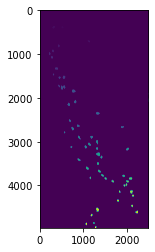

In [6]:
plt.imshow(zstack[0])

In [4]:
minx, maxx, miny, maxy = 'hund', None, None, None
any([minx, maxx, miny, maxy])

True

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from pathlib import Path

In [2]:
from findmycells.microscopyimages import MicroscopyImageLoader

In [3]:
microscopy_image_filepath = Path('/mnt/c/Users/dsege/TEMP/test_project4/00_microscopy_images/tg/#5_tg_old/#5_SN_tg_s2_sfr1.czi')

In [4]:
microscopy_image_loader = MicroscopyImageLoader(filepath = microscopy_image_filepath,
                                                filetype = '.czi')
loaded_zstack = microscopy_image_loader.as_array()

In [5]:
max_value = loaded_zstack.max()
if max_value <= 255:
    pass
elif max_value <= 4095:
    for plane_index in range(loaded_zstack.shape[0]):
        loaded_zstack[plane_index] = (loaded_zstack[plane_index] / 4095 * 255).round(0)
elif max_value <= 65535:
    for plane_index in range(loaded_zstack.shape[0]):
        loaded_zstack[plane_index] = (loaded_zstack[plane_index] / 4095 * 255).round(0)
if loaded_zstack.dtype.name != 'uint8':
    loaded_zstack = loaded_zstack.astype('uint8')

In [6]:
loaded_zstack.dtype

dtype('uint8')

In [7]:
max_projection = np.min(loaded_zstack, axis=0)

In [8]:
max_projection = max_projection[np.newaxis, :]

In [9]:
max_projection.dtype

dtype('uint8')

In [10]:
from skimage.exposure import rescale_intensity

In [11]:
max_projection.min()

0

In [12]:
max_projection.max()

183

In [13]:
max_projection[0].shape

(7649, 4748, 3)

In [14]:
hund = 1.8
int(round(hund, 0))

2

In [35]:
def adjust_brightness_and_contrast(zstack: np.ndarray, percentage_saturated_pixels: float=0.0, channel_adjustment_method: str='globally') -> np.ndarray:
    adjusted_zstack = zstack.copy()
    if percentage_saturated_pixels >= 50:
        message_line0 = 'The percentage of saturated pixels cannot be set to values equal to or higher than 50.\n'
        message_line1 = 'Suggested default (also used by the ImageJ Auto Adjust method): 0.35'
        error_message = message_line0 + message_line1
        raise ValueError(error_message)
    if channel_adjustment_method == 'individually':
        for plane_index in range(adjusted_zstack.shape[0]):
            for channel_index in range(adjusted_zstack.shape[3]):
                in_range_min = int(round(np.percentile(adjusted_zstack[plane_index, :, :, channel_index], percentage_saturated_pixels), 0))
                in_range_max = int(round(np.percentile(adjusted_zstack[plane_index, :, :, channel_index], 100 - percentage_saturated_pixels), 0))
                in_range = (in_range_min, in_range_max)
                adjusted_zstack[plane_index, :, :, channel_index] = rescale_intensity(image = adjusted_zstack[plane_index, :, :, channel_index], in_range = in_range)
    elif channel_adjustment_method == 'globally':
        for plane_index in range(adjusted_zstack.shape[0]):
            in_range_min = int(round(np.percentile(adjusted_zstack[plane_index], percentage_saturated_pixels), 0))
            in_range_max = int(round(np.percentile(adjusted_zstack[plane_index], 100 - percentage_saturated_pixels), 0))
            in_range = (in_range_min, in_range_max)
            adjusted_zstack[plane_index] = rescale_intensity(image = adjusted_zstack[plane_index], in_range = in_range)
    else:
        message_line0 = "The 'channel_adjustment_method' has to be one of: ['individually', 'globally'].\n"
        message_line1 = "-->'individually': the range of intensity values wil be calculated and scaled to the min and max values for each individual channel.\n"
        message_line2 = "-->'globally': the range of intensity values will be calculated from and scaled to the global min and max of all channels.\n" 
        message_line3 = "Either way, min and max values will be determined for each image plane individually."
        error_message = message_line0 + message_line1 + message_line2 + message_line3
        raise NotImplementedError(error_message)
    return adjusted_zstack.copy()

In [47]:
adjusted_loaded_zstack = adjust_brightness_and_contrast(zstack = loaded_zstack, percentage_saturated_pixels=10, channel_adjustment_method='individually')

In [48]:
max_projection.max()

183

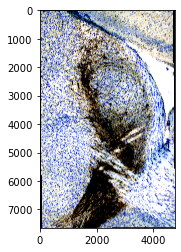

In [51]:
plt.imshow(adjusted_loaded_zstack[1])

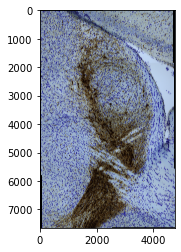

In [32]:
plt.imshow(adjusted_max_projection[0])

In [24]:
50 - 0.3

49.7

In [60]:
np.percentile(max_projection[0, :, :], 0.35)

0.0

In [42]:
max_projection[0][0].max()

140

In [31]:
rescaled_max_projection = max_projection.copy()
rescaled_max_projection[0, :, :, 0] = rescale_intensity(rescaled_max_projection[0, :, :, 0], in_range=(0, 136))
rescaled_max_projection[0, :, :, 1] = rescale_intensity(rescaled_max_projection[0, :, :, 1], in_range=(0, 151))
rescaled_max_projection[0, :, :, 2] = rescale_intensity(rescaled_max_projection[0, :, :, 2], in_range=(0, 171))

NameError: name 'rescale_intensity' is not defined

In [49]:
rescaled_max_projection[0, :, :, 0].min()

0

In [50]:
rescaled_max_projection[0, :, :, 0].max()

255

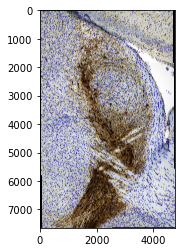

In [57]:
plt.imshow(rescaled_max_projection[0])


In [68]:
rescaled_max_projection2.dtype

dtype('uint8')

In [66]:
rescaled_max_projection2 = max_projection.copy()
rescaled_max_projection2[0, :, :, 0] = rescale_intensity(rescaled_max_projection2[0, :, :, 0], in_range=(0, 100))
rescaled_max_projection2[0, :, :, 1] = rescale_intensity(rescaled_max_projection2[0, :, :, 1], in_range=(0, 100))
rescaled_max_projection2[0, :, :, 2] = rescale_intensity(rescaled_max_projection2[0, :, :, 2], in_range=(0, 100))

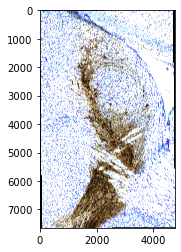

In [67]:
plt.imshow(rescaled_max_projection2[0])

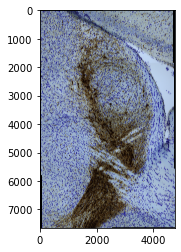

In [59]:
plt.imshow(rescaled_max_projection2[0])

In [39]:
from pathlib import Path
from shapely.geometry import Polygon

from findmycells.rois import ROILoader

In [61]:
roi_filepath = Path('/mnt/c/Users/dsege/TEMP/test_project4/01_rois_to_analyze/tg/#5_tg_old/RoiSet.zip')

In [62]:
roi_loader = ROILoader(filepath = roi_filepath,
                       filetype = '.zip')

In [63]:
rois_dict = roi_loader.as_dict()

In [ ]:
if plane_index == 0:
    min_lower_row_cropping_idx, max_upper_row_cropping_idx = lower_row_idx, upper_row_idx
    min_lower_col_cropping_idx, max_upper_col_cropping_idx = lower_col_idx, upper_col_idx
else:
    if lower_row_idx > min_lower_row_cropping_idx:
        min_lower_row_cropping_idx = lower_row_idx
    if upper_row_idx < max_upper_row_cropping_idx:
        max_upper_row_cropping_idx = upper_row_idx
    if lower_col_idx > min_lower_col_cropping_idx:
        min_lower_col_cropping_idx = lower_col_idx
    if upper_col_idx < max_upper_col_cropping_idx:
        max_upper_col_cropping_idx = upper_col_idx

In [64]:
min_lower_row_cropping_idx, min_lower_col_cropping_idx, max_upper_row_cropping_idx, max_upper_col_cropping_idx = None, None, None, None
for plane_id in rois_dict.keys():
    for roi_id in rois_dict[plane_id].keys():
        lower_row_idx, lower_col_idx, upper_row_idx, upper_col_idx =  rois_dict[plane_id][roi_id].bounds
        if min_lower_row_cropping_idx == None:
            min_lower_row_cropping_idx, max_upper_row_cropping_idx = lower_row_idx, upper_row_idx
            min_lower_col_cropping_idx, max_upper_col_cropping_idx = lower_col_idx, upper_col_idx
        else:
            if lower_row_idx < min_lower_row_cropping_idx:
                min_lower_row_cropping_idx = lower_row_idx
            if upper_row_idx > max_upper_row_cropping_idx:
                max_upper_row_cropping_idx = upper_row_idx
            if lower_col_idx < min_lower_col_cropping_idx:
                min_lower_col_cropping_idx = lower_col_idx
            if upper_col_idx > max_upper_col_cropping_idx:
                max_upper_col_cropping_idx = upper_col_idx
        cropping_indices = {'lower_row_cropping_idx': min_lower_row_cropping_idx,
                            'upper_row_cropping_idx': max_upper_row_cropping_idx,
                            'lower_col_cropping_idx': min_lower_col_cropping_idx,
                            'upper_col_cropping_idx': max_upper_col_cropping_idx}

In [65]:
cropping_indices

{'lower_row_cropping_idx': 40.0,
 'upper_row_cropping_idx': 482.0,
 'lower_col_cropping_idx': 49.0,
 'upper_col_cropping_idx': 348.0}

In [58]:
min_row, min_col, max_row, max_col = None, None, None, None

all([min_row, min_col])

False

In [71]:
for roi_id in rois_dict['all_planes'].keys():
    print(rois_dict['all_planes'][roi_id].bounds)

(40.0, 49.0, 187.0, 149.0)
(150.0, 248.0, 286.0, 348.0)
(288.0, 63.0, 355.0, 194.0)
(397.0, 86.0, 482.0, 253.0)


In [55]:
rois_dict['all_planes']['000'].bounds

(1048.0, 1272.0, 5816.0, 3544.0)

In [ ]:
adjusted_row_coords = [coordinates[0] - lower_row_idx for coordinates in rois_dict[plane_identifier][roi_id].boundary.coords[:]]
adjusted_col_coords = [coordinates[1] - lower_col_idx for coordinates in rois_dict[plane_identifier][roi_id].boundary.coords[:]]

In [56]:
rois_dict['all_planes']['000'].boundary.coords[:]

[(5816.0, 3296.0),
 (5168.0, 2632.0),
 (4400.0, 1840.0),
 (3168.0, 1472.0),
 (2016.0, 1272.0),
 (1208.0, 1384.0),
 (1048.0, 1608.0),
 (1208.0, 2000.0),
 (1544.0, 2328.0),
 (2088.0, 2496.0),
 (2592.0, 2072.0),
 (3504.0, 2400.0),
 (4392.0, 2888.0),
 (4808.0, 3408.0),
 (5568.0, 3544.0),
 (5816.0, 3296.0)]